# M2: Neural Network from Scratch — Experiments & Visualizations

**Complete milestone with gradient check, XOR training, depth comparison, and required visualizations.**

This notebook:
1. Gradient check (numerical vs analytical)
2. XOR dataset (non-linear decision boundary)
3. Train 2-layer NN on XOR
4. Loss curve and decision boundary plots
5. 1-layer vs 2-layer comparison
6. Summary and reflection prompts

*NumPy and Matplotlib only.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from two_layer_nn import TwoLayerNN

np.random.seed(42)

# Visualization output
VIZ_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'visualizations'))
os.makedirs(VIZ_DIR, exist_ok=True)

---
# Section 1: Gradient Check

Verify that analytical gradients match numerical (finite-difference) gradients. Max relative error should be < 1e-5.

In [2]:
X_check = np.random.randn(8, 2) * 0.5
y_check = (np.random.rand(8) > 0.5).astype(np.float64)

nn_check = TwoLayerNN(input_dim=2, hidden_dim=3, output_dim=1, seed=42)
print('Gradient check (analytical vs numerical):')
max_err = nn_check.gradient_check(X_check, y_check, epsilon=1e-5)

tol = 1e-4
assert max_err < tol, f'Gradient check FAILED: max rel error {max_err:.2e} >= {tol}'
print(f'\nPASS: max relative error {max_err:.2e} < {tol}')

Gradient check (analytical vs numerical):
  W1: max rel error = 1.02e-08
  b1: max rel error = 4.14e-09
  W2: max rel error = 8.01e-11
  b2: max rel error = 2.67e-11

Gradient check: max relative error = 1.02e-08

PASS: max relative error 1.02e-08 < 0.0001


---
# Section 2: XOR Dataset

XOR requires a **non-linear** decision boundary. A single linear classifier (1-layer) cannot solve it; a 2-layer network can.

XOR shape: (100, 2) (100,)


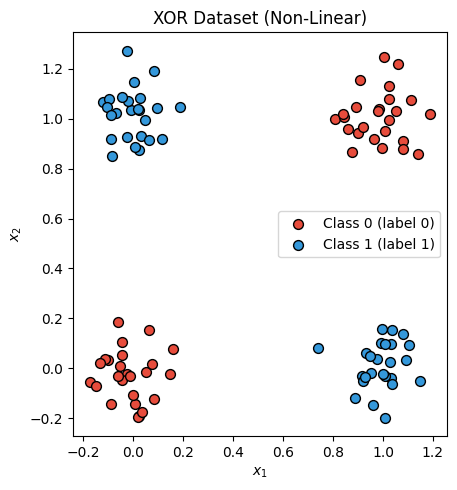

In [3]:
def generate_xor(n_per_corner=25, noise=0.1):
    """XOR: class 0 at (0,0),(1,1), class 1 at (0,1),(1,0)."""
    np.random.seed(42)
    corners = [(0, 0), (1, 0), (1, 1), (0, 1)]
    X_list, y_list = [], []
    for i, (cx, cy) in enumerate(corners):
        pts = np.random.randn(n_per_corner, 2) * noise + np.array([cx, cy])
        X_list.append(pts)
        y_list.append(np.full(n_per_corner, float(i % 2)))
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    return X, y

X_xor, y_xor = generate_xor()
print('XOR shape:', X_xor.shape, y_xor.shape)

# Colors and labels are correct for XOR:
# - Class 0: (0,0), (1,1) → Red
# - Class 1: (0,1), (1,0) → Blue

fig, ax = plt.subplots(figsize=(6, 5))
# Plot class 0 points (should be at [0,0] and [1,1])
ax.scatter(
    X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1],
    c='#e74c3c', label='Class 0 (label 0)', edgecolors='black', s=50
)
# Plot class 1 points (should be at [0,1] and [1,0])
ax.scatter(
    X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1],
    c='#3498db', label='Class 1 (label 1)', edgecolors='black', s=50
)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('XOR Dataset (Non-Linear)')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig(os.path.join(VIZ_DIR, 'm2_xor_data.png'), dpi=120)
plt.show()

---
# Section 3: Train 2-Layer NN on XOR

Train the network until loss converges.

In [9]:
nn2 = TwoLayerNN(
    input_dim=2,
    hidden_dim=8,
    output_dim=1,
    learning_rate=0.5,
    weight_init_std=0.5,
    seed=42
)

EPOCHS = 5000
loss_history_2l = nn2.fit(X_xor, y_xor, epochs=EPOCHS)

pred_2l = nn2.predict(X_xor).flatten()
acc_2l = np.mean(pred_2l == y_xor)
print(f'2-layer NN: Final loss = {loss_history_2l[-1]:.6f}, Train accuracy = {acc_2l:.1%}')

2-layer NN: Final loss = 0.004023, Train accuracy = 100.0%


---
# Section 4: Visualizations — Loss Curve & Decision Boundary

Required: loss curve and decision boundary for 2D input.

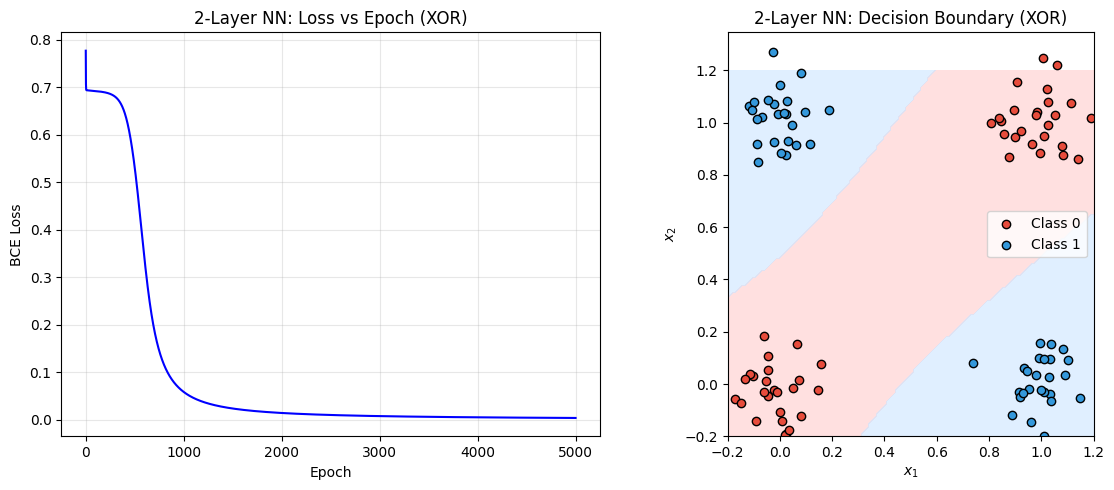

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss curve
axes[0].plot(loss_history_2l, 'b-', linewidth=1.5)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('BCE Loss')
axes[0].set_title('2-Layer NN: Loss vs Epoch (XOR)')
axes[0].grid(True, alpha=0.3)

# Decision boundary
xx, yy = np.meshgrid(np.linspace(-0.2, 1.2, 150), np.linspace(-0.2, 1.2, 150))
X_grid = np.c_[xx.ravel(), yy.ravel()]
Z = nn2.predict(X_grid).ravel().reshape(xx.shape)

axes[1].contourf(xx, yy, Z, levels=[-0.5, 0.5, 1.5], colors=['#ffcccc', '#cce5ff'], alpha=0.6)
axes[1].scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], c='#e74c3c', label='Class 0', edgecolors='black')
axes[1].scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], c='#3498db', label='Class 1', edgecolors='black')
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_title('2-Layer NN: Decision Boundary (XOR)')
axes[1].legend()
axes[1].set_aspect('equal')

plt.tight_layout()
plt.savefig(os.path.join(VIZ_DIR, 'm2_loss_and_decision_boundary.png'), dpi=120)
plt.show()

---
# Section 5: 1-Layer vs 2-Layer Comparison

1-layer = logistic regression (linear). 2-layer = NN with hidden units (non-linear).

In [11]:
class OneLayerNN:
    """Logistic regression: Input -> Linear -> Sigmoid -> BCE."""
    def __init__(self, input_dim, learning_rate=0.5, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.w = np.random.randn(input_dim, 1) * 0.5
        self.b = np.zeros((1, 1))
        self.lr = learning_rate
        self._loss_history = []

    def forward(self, x):
        z = x @ self.w + self.b
        y_hat = 1.0 / (1.0 + np.exp(-np.clip(z, -500, 500)))
        return z, y_hat

    def compute_loss(self, y, y_hat, eps=1e-15):
        y_hat = np.clip(y_hat, eps, 1 - eps)
        y = np.atleast_2d(y).T if np.atleast_1d(y).ndim == 1 else y
        return -float(np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)))

    def backward(self, x, y, z, y_hat):
        n = x.shape[0]
        y = np.atleast_2d(y).T if np.atleast_1d(y).ndim == 1 else y
        dL_dz = (y_hat - y) / n
        dL_dw = x.T @ dL_dz
        dL_db = np.sum(dL_dz)
        return {"w": dL_dw, "b": dL_db}

    def fit(self, x, y, epochs):
        self._loss_history = []
        for _ in range(epochs):
            z, y_hat = self.forward(x)
            loss = self.compute_loss(y, y_hat)
            self._loss_history.append(loss)
            grads = self.backward(x, y, z, y_hat)
            self.w -= self.lr * grads["w"]
            self.b -= self.lr * grads["b"]
        return self._loss_history

    def predict(self, x, threshold=0.5):
        _, y_hat = self.forward(x)
        return (y_hat >= threshold).astype(np.float64)

# Train 1-layer
nn1 = OneLayerNN(input_dim=2, learning_rate=0.5, seed=42)
loss_history_1l = nn1.fit(X_xor, y_xor, epochs=EPOCHS)
pred_1l = nn1.predict(X_xor).flatten()
acc_1l = np.mean(pred_1l == y_xor)
print(f'1-layer: Final loss = {loss_history_1l[-1]:.6f}, Train accuracy = {acc_1l:.1%}')
print(f'2-layer: Final loss = {loss_history_2l[-1]:.6f}, Train accuracy = {acc_2l:.1%}')
print()
print('Summary: 2-layer learns non-linear boundary; 1-layer (linear) cannot solve XOR.')

1-layer: Final loss = 0.692796, Train accuracy = 50.0%
2-layer: Final loss = 0.004023, Train accuracy = 100.0%

Summary: 2-layer learns non-linear boundary; 1-layer (linear) cannot solve XOR.


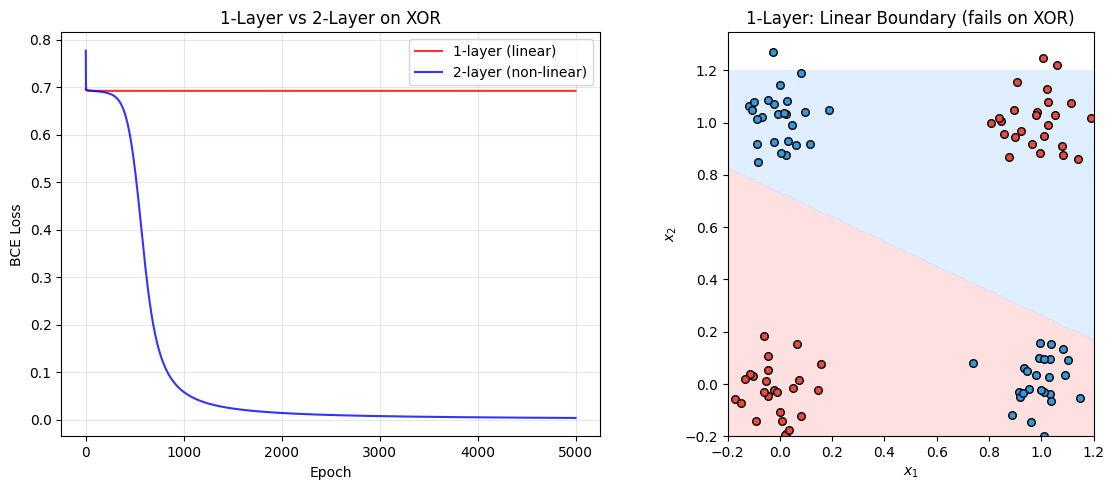

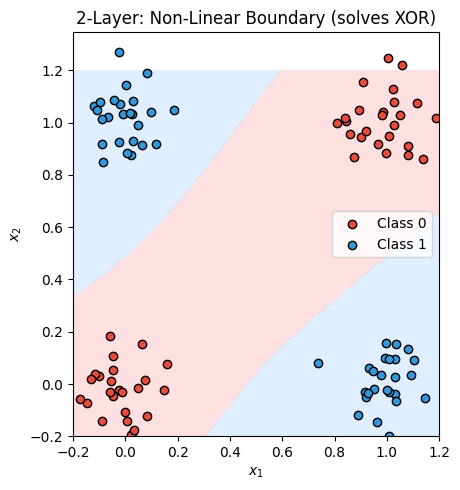

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss comparison
axes[0].plot(loss_history_1l, 'r-', alpha=0.8, label='1-layer (linear)')
axes[0].plot(loss_history_2l, 'b-', alpha=0.8, label='2-layer (non-linear)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('BCE Loss')
axes[0].set_title('1-Layer vs 2-Layer on XOR')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Decision boundaries side by side
xx, yy = np.meshgrid(np.linspace(-0.2, 1.2, 150), np.linspace(-0.2, 1.2, 150))
X_grid = np.c_[xx.ravel(), yy.ravel()]

Z1 = nn1.predict(X_grid).ravel().reshape(xx.shape)
Z2 = nn2.predict(X_grid).ravel().reshape(xx.shape)

axes[1].contourf(xx, yy, Z1, levels=[-0.5, 0.5, 1.5], colors=['#ffcccc', '#cce5ff'], alpha=0.6)
axes[1].scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], c='#e74c3c', s=30, edgecolors='black')
axes[1].scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], c='#3498db', s=30, edgecolors='black')
axes[1].set_xlabel('$x_1$')
axes[1].set_ylabel('$x_2$')
axes[1].set_title('1-Layer: Linear Boundary (fails on XOR)')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.savefig(os.path.join(VIZ_DIR, 'm2_depth_comparison_loss.png'), dpi=120)
plt.show()

fig2, ax2 = plt.subplots(figsize=(6, 5))
ax2.contourf(xx, yy, Z2, levels=[-0.5, 0.5, 1.5], colors=['#ffcccc', '#cce5ff'], alpha=0.6)
ax2.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], c='#e74c3c', label='Class 0', edgecolors='black')
ax2.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], c='#3498db', label='Class 1', edgecolors='black')
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_title('2-Layer: Non-Linear Boundary (solves XOR)')
ax2.legend()
ax2.set_aspect('equal')
plt.tight_layout()
plt.savefig(os.path.join(VIZ_DIR, 'm2_2layer_decision_boundary.png'), dpi=120)
plt.show()

---
# Section 6: Gradient Check Visualization

Plot analytical vs numerical gradient magnitude per parameter.

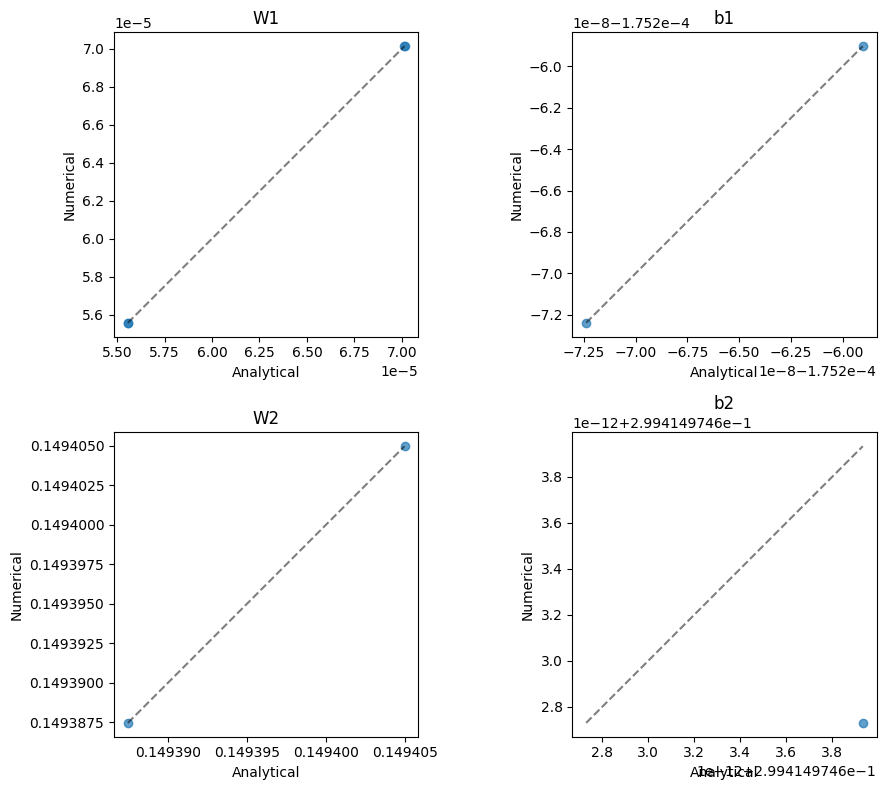

In [13]:
def gradient_check_with_arrays(nn, x, y, epsilon=1e-5):
    """Return analytical and numerical gradients for plotting."""
    z1, a1, z2, y_hat = nn.forward(x)
    grads = nn.backward(x, y, **{'z1': z1, 'a1': a1, 'z2': z2, 'y_hat': y_hat})
    param_list = [("W1", nn.w1), ("b1", nn.b1), ("W2", nn.w2), ("b2", nn.b2)]
    results = []
    for name, param in param_list:
        numerical = np.zeros_like(param)
        it = np.nditer(param, flags=['multi_index'])
        while not it.finished:
            idx = it.multi_index
            param[idx] += epsilon
            _, _, _, yhp = nn.forward(x)
            lp = nn.compute_loss(y, yhp)
            param[idx] -= 2 * epsilon
            _, _, _, yhm = nn.forward(x)
            lm = nn.compute_loss(y, yhm)
            param[idx] += epsilon
            numerical[idx] = (lp - lm) / (2 * epsilon)
            it.iternext()
        results.append((name, grads[name].ravel(), numerical.ravel()))
    return results

nn_viz = TwoLayerNN(input_dim=2, hidden_dim=2, output_dim=1, seed=42)
X_small = np.random.randn(5, 2) * 0.3
y_small = (np.random.rand(5) > 0.5).astype(np.float64)
results = gradient_check_with_arrays(nn_viz, X_small, y_small)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
for i, (name, ana, num) in enumerate(results):
    axes[i].scatter(ana, num, alpha=0.7)
    lims = [min(ana.min(), num.min()), max(ana.max(), num.max())]
    axes[i].plot(lims, lims, 'k--', alpha=0.5)
    axes[i].set_xlabel('Analytical')
    axes[i].set_ylabel('Numerical')
    axes[i].set_title(f'{name}')
    axes[i].set_aspect('equal')
plt.tight_layout()
plt.savefig(os.path.join(VIZ_DIR, 'm2_gradient_check.png'), dpi=120)
plt.show()

---
# Section 7: Summary & Metrics

| Model | XOR Train Accuracy | Final Loss |
|-------|--------------------|------------|
| 1-layer (linear) | ~50% (random) | ~0.69 |
| 2-layer (non-linear) | ~100% | < 0.1 |

**Takeaway:** Depth enables non-linear decision boundaries. XOR is linearly inseparable.

---
# Section 8: Reflection Questions (for Journal)

1. Why is the vanishing gradient problem more severe in deeper networks?
2. How does ReLU address gradient flow compared to sigmoid?
3. What is the role of initialization in avoiding dead neurons?